In [1]:
import os
import numpy as np
import cv2
import glob
import imutils
import pandas as pd
import matplotlib.pyplot as plt
import random
from function import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

2023-05-15 13:41:42.662310: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-15 13:41:42.662326: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Count total images
data_dir = '../data'
total_images = glob.glob(data_dir+'/Images/*.*')
len(total_images)

8091

In [3]:
df_text = pd.read_csv(data_dir+'/captions.txt', sep = ',')
df_text.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [4]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    40455 non-null  object
 1   caption  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB


In [5]:
len(df_text['image'].unique())

8091

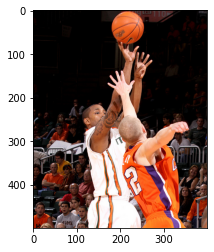

A basketball player shooting while another player is trying to block his shot .
A basketball player tries to block another .
Two basketball players reaching for a ball .
Two men are playing Basketball
two men jump for the basketball .


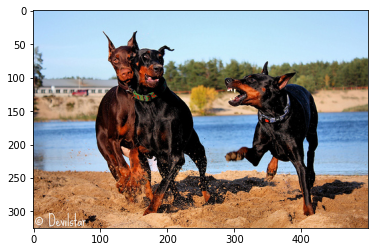

One dog baring teeth at two other dogs running on the sand .
One dog is bearing its teeth at the other two dogs as they run beside the water .
The dog on the right is baring his teeth at the other two dogs .
The three dogs are running through sand near a lake .
Three dogs fighting on the shore of a lake .


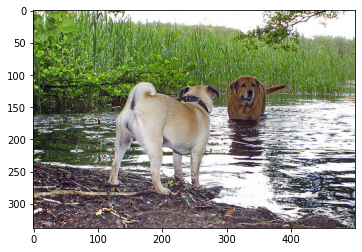

A pet dog , standing on bank is looking at another brown dog inside a pond .
A pug stands on the bank of a pond while a larger dog stands in the water .
A tan dog watching a brown dog swimming in a pond .
One dog wades in the water while another dog is on land .
Two dogs wade in water by green vegetation .


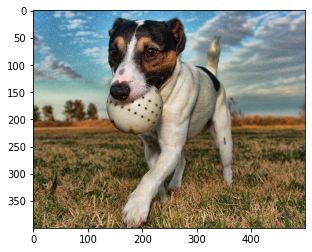

a closeup photo of a small dog with a holey ball in his mouth .
A dog carrying a white ball .
A dog fetches a ball in a field .
A dog trots with a ball in its mouth .
The dog is carrying a whiffle ball outside


In [6]:
show_img_desc(total_images, df_text, 4)

In [7]:
# Text processing
df_text['pre_caption'] = df_text['caption'].apply(lambda x: text_reprocess(x))
df_text.head()

,image,caption,pre_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,[start]a child in a pink dress is climbing up ...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,[start]a girl going into a wooden building .[end]
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,[start]a little girl climbing into a wooden pl...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,[start]a little girl climbing the stairs to he...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,[start]a little girl in a pink dress going int...


In [8]:
# Tokenizer Text

maximum_word = 5000
tokenizer = Tokenizer(maximum_word+1, filters='!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False, 
                      oov_token = 'UNK')

# Fit token into pre_caption columns
tokenizer.fit_on_texts(df_text['pre_caption'])
tokenizer

In [9]:
transform_text_seqs = tokenizer.texts_to_sequences(df_text['pre_caption'])

In [16]:
transform_text_seqs[:5]

[[4, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 3],
 [4, 2, 20, 317, 65, 2, 197, 118, 3],
 [4, 2, 41, 20, 120, 65, 2, 197, 2436, 3],
 [4, 2, 41, 20, 120, 6, 395, 21, 61, 2436, 3],
 [4, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2980, 3]]

In [11]:
test_token = tokenizer.texts_to_sequences(['a cat in a hat', 'a robot dog'])
test_token

[[2, 591, 5, 2, 96], [2, 2015, 10]]

In [12]:
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [13]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [17]:
len(transform_text_seqs)

40455

In [21]:
max_len_seq = max([len(i) for i in transform_text_seqs])
max_len_seq

39

In [22]:
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(transform_text_seqs, padding= 'post', maxlen = max_len_seq,
                                                          dtype='int32', value=0)

In [23]:
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


In [1]:
import pandas as pd